In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
#loading the csv data to a Pandas Dataframe
df = pd.read_csv('/content/sample_data/dataset1water (1).csv')

In [3]:
#printing first 5 rows of the dataframe
df.head()

,Well ID,S.No,STATE,DISTRICT,BLOCK,LOCATION,LATITUDE,LONGITUDE,Year,pH,...,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,W113126092431802,1,A&N Islands,South Andaman,PORT BLAIR,Kodiaghat,11.545,92.74583,2021,7.74,...,25.0,1.0,1.0,175.0,34.0,22.0,10.0,0.0,0.84,206.0
1,W113616092411001,2,A&N Islands,South Andaman,PORT BLAIR,Sippighat,11.6025,92.73,2021,7.53,...,82.0,5.0,1.0,250.0,52.0,29.0,51.0,1.0,0.28,381.0
2,W113640092443301,3,A&N Islands,South Andaman,PORT BLAIR,Brichganj,11.62083,92.73028,2021,7.50,...,35.0,1.0,0.0,125.0,4.0,28.0,10.0,1.0,0.46,151.0
3,W114421092422801,4,A&N Islands,South Andaman,FERRARGUNJ,Wimberleyganj,11.7325,92.70861,2021,7.60,...,39.0,2.0,0.0,135.0,26.0,17.0,15.0,2.0,0.37,198.0
4,W113955092391801,5,A&N Islands,South Andaman,FERRARGUNJ,Ograbraj,11.66361,92.65806,2021,7.82,...,560.0,56.0,5.0,465.0,56.0,79.0,336.0,18.0,0.95,1424.0


In [4]:
# Checking size of the dataset
df.shape

(5375, 23)

In [5]:
# Checking for datatypes of the dataset
df.dtypes

Well ID       object
S.No           int64
STATE         object
DISTRICT      object
BLOCK         object
LOCATION      object
LATITUDE      object
LONGITUDE     object
Year           int64
pH           float64
EC           float64
CO3          float64
HCO3         float64
Cl           float64
SO4          float64
NO3          float64
TH           float64
Ca           float64
Mg           float64
Na           float64
K            float64
F            float64
TDS          float64
dtype: object

# Converting object data type to numeric

In [6]:
def convert_to_numeric(df):
    num_col = df.shape[1]
    # Start from index 6
    for index in range(6, num_col):
        col_name = df.iloc[:, index].name
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
    return df

df = convert_to_numeric(df)
df.dtypes

Well ID       object
S.No           int64
STATE         object
DISTRICT      object
BLOCK         object
LOCATION      object
LATITUDE     float64
LONGITUDE    float64
Year           int64
pH           float64
EC           float64
CO3          float64
HCO3         float64
Cl           float64
SO4          float64
NO3          float64
TH           float64
Ca           float64
Mg           float64
Na           float64
K            float64
F            float64
TDS          float64
dtype: object

In [7]:
df.isnull().sum()

Well ID         0
S.No            0
STATE           0
DISTRICT        0
BLOCK          71
LOCATION        0
LATITUDE      811
LONGITUDE     810
Year            0
pH              0
EC              0
CO3             0
HCO3            0
Cl              0
SO4             1
NO3             0
TH              0
Ca              0
Mg              0
Na              0
K               1
F               0
TDS          2159
dtype: int64

# Handling null values

In [8]:
df['BLOCK'].fillna("not specified",inplace = True)
df['LATITUDE'].fillna(method='bfill', inplace=True)
df['LONGITUDE'].fillna(method='bfill', inplace=True)
# df['SO4'].fillna(method='bfill', inplace=True)
# df['K'].fillna(method='bfill', inplace=True)
df['SO4'].fillna(df.SO4.mean(), inplace=True)
df['K'].fillna(df.K.mean(), inplace=True)
df['TDS'].fillna(df.TDS.mean(), inplace=True)

In [9]:
df.isnull().sum()

Well ID      0
S.No         0
STATE        0
DISTRICT     0
BLOCK        0
LOCATION     0
LATITUDE     0
LONGITUDE    0
Year         0
pH           0
EC           0
CO3          0
HCO3         0
Cl           0
SO4          0
NO3          0
TH           0
Ca           0
Mg           0
Na           0
K            0
F            0
TDS          0
dtype: int64

# Set of parameters that are required to build predictive model

In [10]:
Required_parameters= df.drop(columns=["Well ID","S.No","Year","STATE","DISTRICT","BLOCK","LOCATION","LATITUDE","LONGITUDE"])

# Water Quality Index (WQI) Calculation

In [11]:
# Define Weight for each parameter
weights = {
    'pH': 0.10,    # Weight assigned to pH
    'EC': 0.12,    # Weight assigned to Electrical Conductivity
    'Cl': 0.08,    # Weight assigned to Chloride
    'TH': 0.10,    # Weight assigned to Total Hardness
    'Ca': 0.10,    # Weight assigned to Calcium
    'Mg': 0.10,    # Weight assigned to Magnesium
    'TDS': 0.15,   # Weight assigned to Total Dissolved Solids
    'HCO3': 0.08,  # Weight assigned to Bicarbonate
    'CO3': 0.07,   # Weight assigned to Carbonate
    'SO4': 0.08,   # Weight assigned to Sulfate
    'NO3': 0.05,   # Weight assigned to Nitrate
    'Na': 0.08,    # Weight assigned to Sodium
    'K': 0.07,     # Weight assigned to Potassium
    'F': 0.07      # Weight assigned to Fluoride
}

# Standard ranges for each parameter
standard_ranges = {
    'pH': [6.5, 8.5],   # pH level
    'EC': [50, 800],    # Electrical Conductivity (μS/cm)
    'Cl': [250, 600],   # Chloride (mg/L)
    'TH': [100, 300],   # Total Hardness (mg/L CaCO3)
    'Ca': [20, 120],    # Calcium (mg/L)
    'Mg': [10, 50],     # Magnesium (mg/L)
    'TDS': [300, 2000], # Total Dissolved Solids (mg/L)
    'HCO3': [0, 400],   # Bicarbonate (mg/L)
    'CO3': [0, 200],    # Carbonate (mg/L)
    'SO4': [0, 400],    # Sulfate (mg/L)
    'NO3': [0, 50],     # Nitrate (mg/L)
    'Na': [0, 200],     # Sodium (mg/L)
    'K': [0, 50],       # Potassium (mg/L)
    'F': [0, 2]         # Fluoride (mg/L)
}

# Create an empty list to store WQI values for each row
wqi_values = []

# Loop through each row
for index, row in Required_parameters.iterrows():

    # Initialize WQI for the current row
    wqi = 0

    # Loop through each parameter for the current row
    for param in Required_parameters.columns:
        # Calculate sub-index for the current parameter
        sub_index = 100 * (row[param] - standard_ranges[param][0]) / (standard_ranges[param][1] - standard_ranges[param][0])

        # Add to the WQI for the current row
        wqi += sub_index * weights[param]

    # Append the WQI value to the list
    wqi_values.append(wqi)

# Add the WQI values as a new column to the original DataFrame
df['WQI'] = wqi_values
#normalized_data['WQI']= wqi_values

# Display the DataFrame with WQI values
print(df)
#print(normalized_data)


               Well ID  S.No        STATE       DISTRICT       BLOCK  \
0     W113126092431802     1  A&N Islands  South Andaman  PORT BLAIR   
1     W113616092411001     2  A&N Islands  South Andaman  PORT BLAIR   
2     W113640092443301     3  A&N Islands  South Andaman  PORT BLAIR   
3     W114421092422801     4  A&N Islands  South Andaman  FERRARGUNJ   
4     W113955092391801     5  A&N Islands  South Andaman  FERRARGUNJ   
...                ...   ...          ...            ...         ...   
5370  W220500091040001  5371      Tripura  South Tripura    Satchand   
5371  W235602091511501  5372      Tripura         Dhalai     Ambassa   
5372  W230605091513506  5373      Tripura          Gomti       Killa   
5373  W240824092090501  5374      Tripura        Unakoti  Pecharthal   
5374  W232915091240601  5375      Tripura          Gomti  Kankra-ban   

           LOCATION   LATITUDE  LONGITUDE  Year    pH  ...    SO4   NO3  \
0         Kodiaghat  11.545000  92.745830  2021  7.74  ...  

# Multiclass

In [12]:
# 0-25  very bad
# 25-50 bad
# 50-70 Medium
# 70-90 Good
# 90-100 Excellent

# Multiclass Classification is used for more detailed results
df['Potability'] = df['WQI'].apply(lambda x: '0' if x < 25 else ('1' if x < 50 else ('2' if x < 70 else ('3' if x < 90 else '4'))))
#normalized_data['Potability'] = normalized_data['WQI'].apply(lambda x: '0' if x < 25 else ('1' if x < 50 else ('2' if x < 70 else ('3' if x < 90 else '4'))))

# Display the DataFrame
print(df)
#print(normalized_data)

               Well ID  S.No        STATE       DISTRICT       BLOCK  \
0     W113126092431802     1  A&N Islands  South Andaman  PORT BLAIR   
1     W113616092411001     2  A&N Islands  South Andaman  PORT BLAIR   
2     W113640092443301     3  A&N Islands  South Andaman  PORT BLAIR   
3     W114421092422801     4  A&N Islands  South Andaman  FERRARGUNJ   
4     W113955092391801     5  A&N Islands  South Andaman  FERRARGUNJ   
...                ...   ...          ...            ...         ...   
5370  W220500091040001  5371      Tripura  South Tripura    Satchand   
5371  W235602091511501  5372      Tripura         Dhalai     Ambassa   
5372  W230605091513506  5373      Tripura          Gomti       Killa   
5373  W240824092090501  5374      Tripura        Unakoti  Pecharthal   
5374  W232915091240601  5375      Tripura          Gomti  Kankra-ban   

           LOCATION   LATITUDE  LONGITUDE  Year    pH  ...   NO3     TH  \
0         Kodiaghat  11.545000  92.745830  2021  7.74  ...  

In [13]:
df['Potability'].value_counts()

Potability
1    1656
0    1285
4    1046
2     859
3     529
Name: count, dtype: int64

SMOTE

In [14]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Assuming your data is stored in a pandas DataFrame called 'data'
# with the target variable named 'Potability'

# First, split your data into features (X) and target variable (y)
X = df[['pH','EC','CO3','HCO3','Cl','SO4','NO3','TH','Ca','Mg','Na','K','F','TDS']]
y = df['Potability']

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the resampled data
resampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Potability'])], axis=1)

# Now 'resampled_data' contains your balanced dataset


In [15]:
resampled_data

,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS,Potability
0,7.740000,349.000000,0.000000,183.000000,25.000000,1.000000,1.000000,175.000000,34.000000,22.000000,10.000000,0.000000,0.840000,206.000000,0
1,7.530000,660.000000,0.000000,262.000000,82.000000,5.000000,1.000000,250.000000,52.000000,29.000000,51.000000,1.000000,0.280000,381.000000,1
2,7.500000,270.000000,0.000000,116.000000,35.000000,1.000000,0.000000,125.000000,4.000000,28.000000,10.000000,1.000000,0.460000,151.000000,0
3,7.600000,311.000000,0.000000,159.000000,39.000000,2.000000,0.000000,135.000000,26.000000,17.000000,15.000000,2.000000,0.370000,198.000000,0
4,7.820000,2501.000000,0.000000,512.000000,560.000000,56.000000,5.000000,465.000000,56.000000,79.000000,336.000000,18.000000,0.950000,1424.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,7.570795,2094.867529,0.000000,231.240502,532.565208,101.629082,62.488663,859.578149,195.611420,89.894024,84.538714,0.685664,0.308145,1403.540769,4
8276,8.161114,2325.401762,0.000000,471.260977,486.923766,95.466264,41.375378,706.903223,38.046928,148.428147,221.000000,27.061581,0.992199,870.131197,4
8277,7.829427,2601.585846,0.000000,252.361161,523.339221,283.370050,147.788591,818.854635,90.748875,144.052880,232.259901,1.192068,0.628238,1740.317169,4
8278,8.699348,1314.802827,37.489399,407.204240,113.438339,127.575795,51.137455,338.468198,16.408480,72.387279,151.341695,54.739523,0.914737,865.880992,4


In [16]:
resampled_data['Potability'].value_counts()

Potability
0    1656
1    1656
4    1656
2    1656
3    1656
Name: count, dtype: int64

In [17]:
Required_parameters= resampled_data.drop(columns=["Potability"])

# Boxplot to view outliers

(8280, 14)

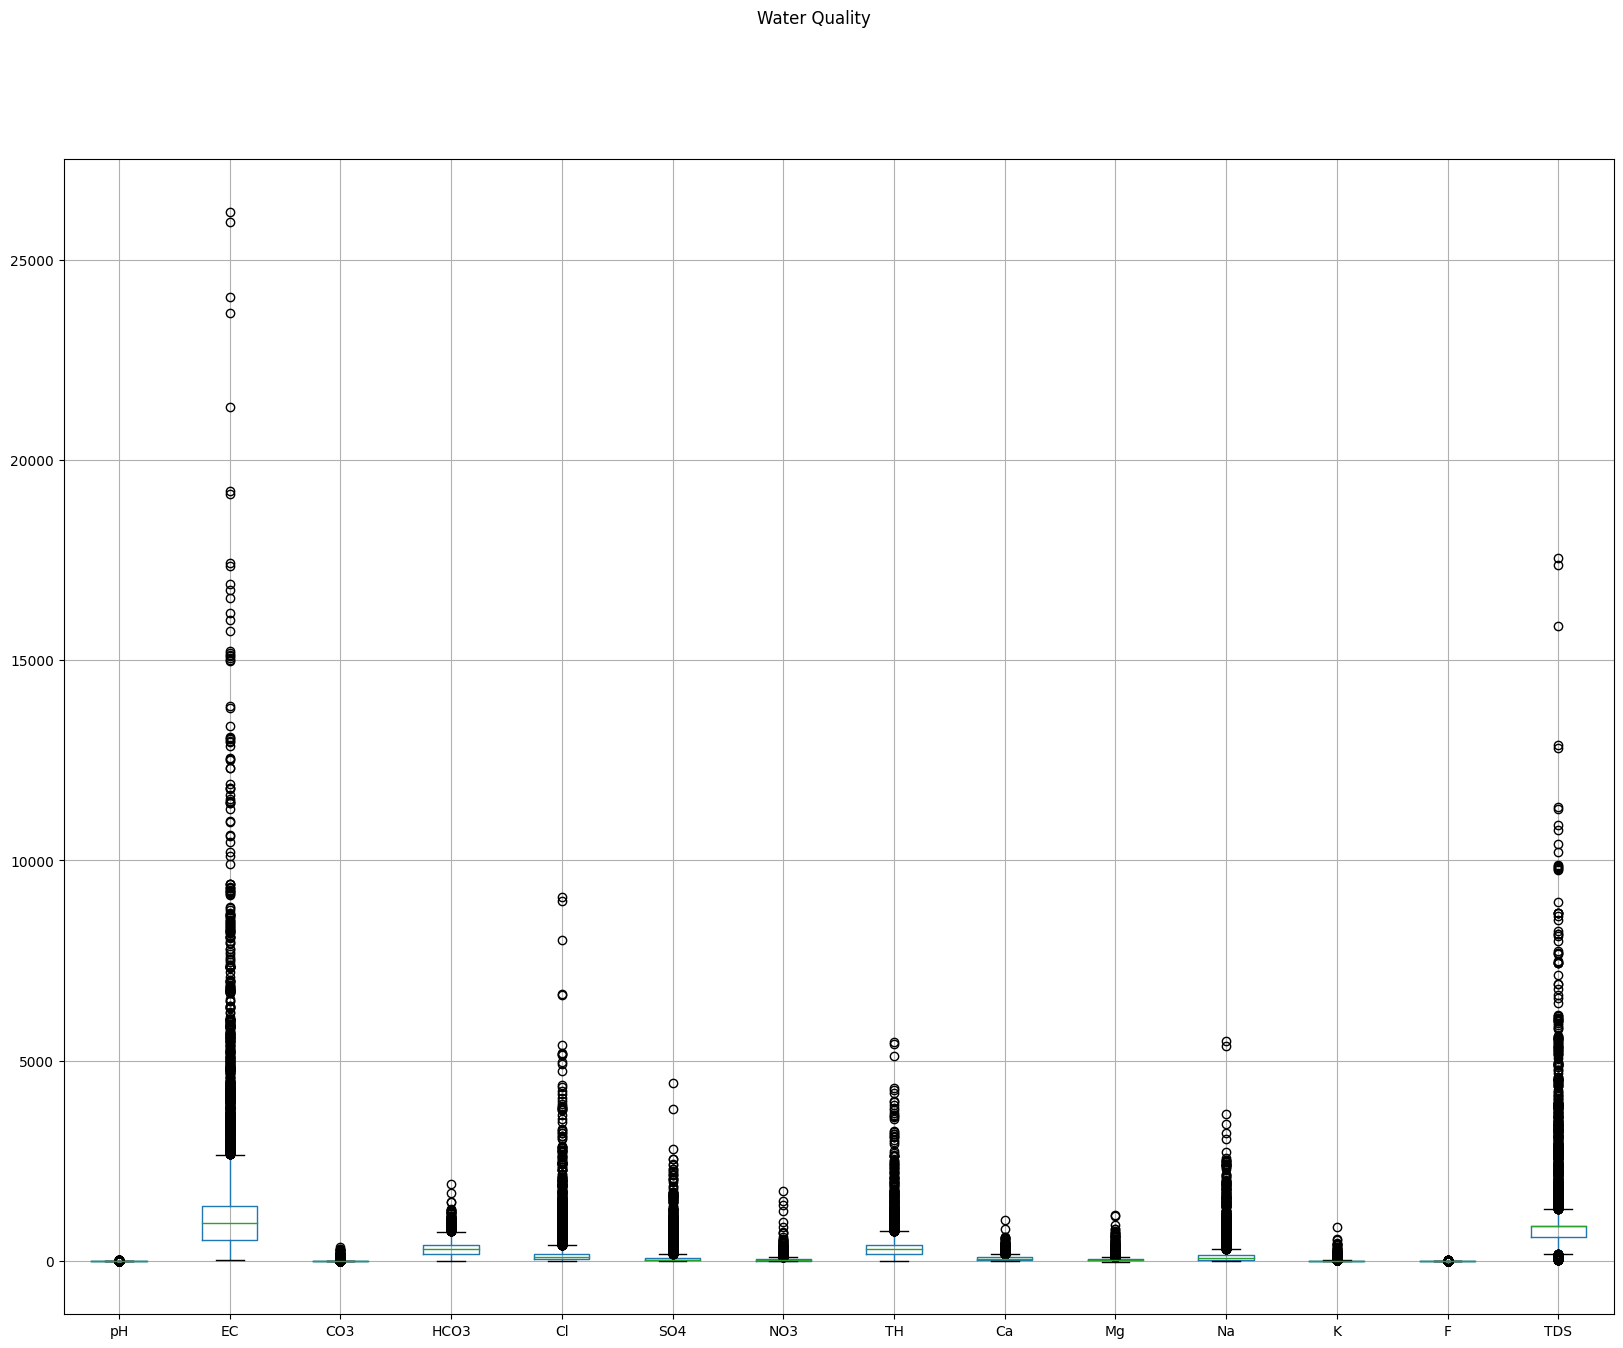

In [18]:
plt.figure(figsize=(20,15))
plt.suptitle("Water Quality")
ax = plt.gca()

Required_parameters.boxplot()
Required_parameters.shape

# Z-score For outlier Handling




Number of outliers using Z-Score method- 729


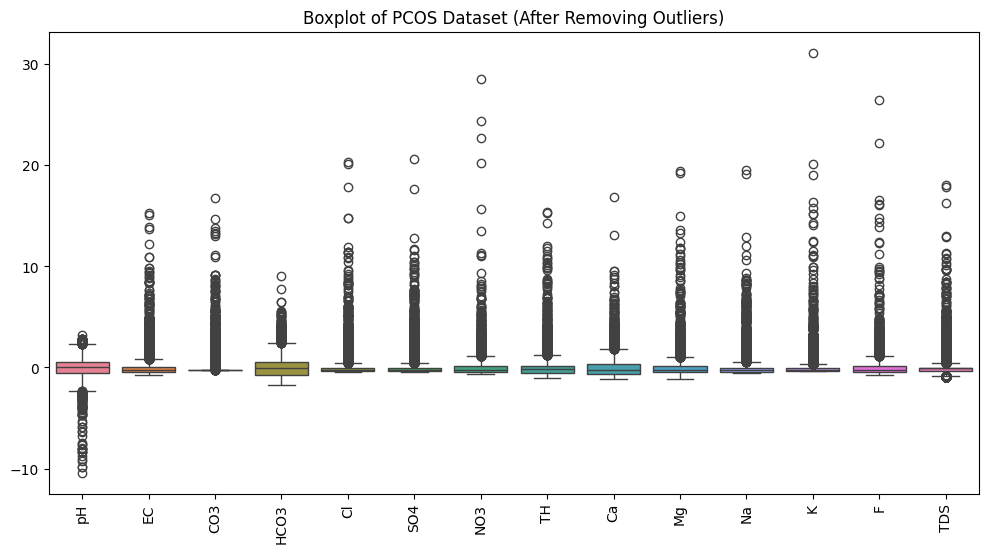

(8280, 14)

In [19]:
#remove outliner by z-score
from scipy import stats
# Here, almost all kde plots are Gaussian Like
# Using Z-Score Normalization to detect outliers
df_num_final = Required_parameters
df_final_norm = zscore(df_num_final, axis=0)


def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[: ,index]
        greater_than_3 = df_norm[col_index > 5]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_final_norm)
print("Number of outliers using Z-Score method-",len(indices_arr))
Required_parameters.iloc[indices_arr, :]


#Remove outliners using z-score
# Calculate Z-scores for each column
z_scores = stats.zscore(df_final_norm)

threshold = 3

# Identify and remove rows with Z-scores above the threshold
indices_arr = (abs(z_scores) > threshold).any(axis=1)
df_no_outliers = df_final_norm[~indices_arr]

# Print the resulting DataFrame without outliers
# print(df_no_outliers)

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(df_final_norm)
plt.title("Boxplot of PCOS Dataset (After Removing Outliers)")
plt.xticks(rotation=90)
plt.show()

df_final_norm.shape

# Data Normalization

In [20]:
from sklearn.preprocessing import MinMaxScaler

min_range = 0
max_range = 1

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(min_range, max_range))

# Normalize the DataFrame
normalized_data = pd.DataFrame(scaler.fit_transform(df_final_norm), columns=df_final_norm.columns)

normalized_data

,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,0.756058,0.012297,0.000000,0.095561,0.002557,0.000226,0.000571,0.030947,0.031812,0.038827,0.001822,0.000000,0.037668,0.010862
1,0.722132,0.024180,0.000000,0.136815,0.008839,0.001129,0.000571,0.044714,0.049595,0.044866,0.009291,0.001186,0.012556,0.020840
2,0.717286,0.009279,0.000000,0.060574,0.003659,0.000226,0.000000,0.021770,0.002173,0.044003,0.001822,0.001186,0.020628,0.007726
3,0.733441,0.010846,0.000000,0.083029,0.004100,0.000451,0.000000,0.023605,0.023908,0.034513,0.002733,0.002372,0.016592,0.010406
4,0.768982,0.094520,0.000000,0.267363,0.061522,0.012641,0.002857,0.084178,0.053547,0.088007,0.061213,0.021352,0.042601,0.080310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,0.728723,0.079003,0.000000,0.120752,0.058498,0.022941,0.035708,0.156605,0.191475,0.097406,0.015401,0.000813,0.013818,0.079143
8276,0.824090,0.087811,0.000000,0.246089,0.053468,0.021550,0.023643,0.128581,0.035810,0.147910,0.040262,0.032102,0.044493,0.048729
8277,0.770505,0.098363,0.000000,0.131781,0.057481,0.063966,0.084451,0.149130,0.087877,0.144135,0.042314,0.001414,0.028172,0.098345
8278,0.911042,0.049198,0.107728,0.212639,0.012304,0.028798,0.029221,0.060953,0.014432,0.082301,0.027572,0.064934,0.041020,0.048487


#RFE

In [21]:
from sklearn.feature_selection import RFE

In [24]:
# Splitting the dataset into features (X) and target (y)
X_rfe = normalized_data
y_rfe = resampled_data['Potability']

In [25]:
# Splitting the dataset into the Training set and Test set
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe, y_rfe, test_size=0.2, random_state=0)

1.Recursive Feature Elimination -Logistic Regression with RFE

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
lr_model = LogisticRegression()  # Initialize Logistic Regression and RFE
rfe_lr_model = RFE(lr_model, n_features_to_select=10) # Adjust the number of features as needed

# Perform RFE
rfe_lr_model.fit(X_train_rfe, y_train_rfe)

# Extract selected features
lr_selected_features = X_train_rfe.columns[rfe_lr_model.support_]

# Train a model on selected features
lr_model.fit(X_train_rfe[lr_selected_features], y_train_rfe)

# Making predictions on the training set
rfe_logistic_train_pred = lr_model.predict(X_train_rfe[lr_selected_features])

# Calculating the accuracy scores
rfe_lr_accuracy_train = accuracy_score(y_train_rfe, rfe_logistic_train_pred)
# print("\nTraining Accuracy Score:", rfe_lr_accuracy_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [27]:
lr_selected_features

Index(['EC', 'HCO3', 'Cl', 'SO4', 'NO3', 'TH', 'Ca', 'Mg', 'Na', 'TDS'], dtype='object')

In [28]:
lr_feature_ranking = rfe_lr_model.ranking_
lr_feature_ranking_df = pd.DataFrame({
    'Feature': X_train_rfe.columns,
    'Rank': lr_feature_ranking
})

# Sort the DataFrame based on the rank
lr_feature_ranking_df = lr_feature_ranking_df.sort_values(by='Rank')

lr_feature_ranking_df.head(len(lr_selected_features))

,Feature,Rank
1,EC,1
3,HCO3,1
4,Cl,1
5,SO4,1
6,NO3,1
7,TH,1
8,Ca,1
9,Mg,1
10,Na,1
13,TDS,1


In [29]:
# Array of selected features
lr_features_arr = X_test_rfe.iloc[:,[1,3,4,5,6,7,8,9,10,13]].values

# Testing on selected features
# Making predictions on the testing set
rfe_logistic_test_pred = lr_model.predict(X_test_rfe[lr_selected_features])

# Calculating the accuracy scores
rfe_lr_accuracy_test = accuracy_score(y_test_rfe, rfe_logistic_test_pred)

In [30]:
# :Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
rfe_lr_cv_scores = cross_val_score(lr_model, lr_features_arr, y_test_rfe, cv=5, scoring='accuracy')

In [31]:
print("\nTraining Accuracy Score:", rfe_lr_accuracy_train)
print("Testing Accuracy Score:", rfe_lr_accuracy_test)
print("Mean CV Score on testing data:", np.mean(rfe_lr_cv_scores))
# Precision score on test data
precision_lr = precision_score(y_test_rfe, rfe_logistic_test_pred, average='weighted')
print('Precision:', precision_lr)

# Recall score on test data
recall_lr = recall_score(y_test_rfe, rfe_logistic_test_pred, average='weighted')
print('Recall:', recall_lr)

# F1-score on test data
f1_lr = f1_score(y_test_rfe, rfe_logistic_test_pred, average='weighted')
print('F1-score:', f1_lr)

# Predict probabilities for ROC AUC
y_probabilities_lr = lr_model.predict_proba(X_test_rfe[lr_selected_features])

# ROC area under the curve score
roc_auc_lr = roc_auc_score(y_test_rfe, y_probabilities_lr, average='weighted', multi_class='ovr')
print('ROC area:', roc_auc_lr)


Training Accuracy Score: 0.7370169082125604
Testing Accuracy Score: 0.7542270531400966
Mean CV Score on testing data: 0.6527881920430968
Precision: 0.7573590779093236
Recall: 0.7542270531400966
F1-score: 0.7491196116806803
ROC area: 0.9417040295509896


2.Recursive Feature Elimination -Random Forest With RFE

In [32]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest and RFE
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust parameters as needed
rfe_rf_model = RFE(rf_model, n_features_to_select=10)  # Adjust the number of features as needed

# Perform RFE
rfe_rf_model.fit(X_train_rfe, y_train_rfe)

# Extract selected features
rf_selected_features = X_train_rfe.columns[rfe_rf_model.support_]

# Train a Random Forest model on selected features
rf_model.fit(X_train_rfe[rf_selected_features], y_train_rfe)

# Making predictions on the training set
rfe_rf_train_pred = rf_model.predict(X_train_rfe[rf_selected_features])

# Calculating the accuracy scores
rfe_rf_accuracy_train = accuracy_score(y_train_rfe, rfe_rf_train_pred)

In [33]:
rf_feature_ranking = rfe_rf_model.ranking_
rf_feature_ranking_df = pd.DataFrame({
    'Feature': X_train_rfe.columns,
    'Rank': rf_feature_ranking
})

# Sort the DataFrame based on the rank
rf_feature_ranking_df = rf_feature_ranking_df.sort_values(by='Rank')

rf_feature_ranking_df.head(len(rf_selected_features))

,Feature,Rank
0,pH,1
1,EC,1
3,HCO3,1
4,Cl,1
6,NO3,1
7,TH,1
8,Ca,1
9,Mg,1
10,Na,1
13,TDS,1


In [34]:
rf_features_arr = X_test_rfe.iloc[:,[0,1,3,4,6,7,8,9,10,13]].values

# Making predictions on the testing set
rfe_rf_test_pred = rf_model.predict(X_test_rfe[rf_selected_features])

# Calculating the accuracy scores
rfe_rf_accuracy_test = accuracy_score(y_test_rfe, rfe_rf_test_pred)

In [35]:
# Perform cross-validation on testing dataset
rfe_rf_cv_scores = cross_val_score(rf_model, rf_features_arr, y_test_rfe, cv=10, scoring='accuracy')

In [36]:
print("Random Forest Training Accuracy Score:", rfe_rf_accuracy_train)
print("Testing Accuracy Score:", rfe_rf_accuracy_test)
print("Mean CV Score on testing data:", np.mean(rfe_rf_cv_scores))
# Precision score on test data
precision_rf = precision_score(y_test_rfe, rfe_rf_test_pred, average='weighted')
print('Precision:', precision_rf)

# Recall score on test data
recall_rf = recall_score(y_test_rfe, rfe_rf_test_pred, average='weighted')
print('Recall:', recall_rf)

# F1-score on test data
f1_rf = f1_score(y_test_rfe, rfe_rf_test_pred, average='weighted')
print('F1-score:', f1_rf)

# Predict probabilities for ROC AUC
y_probabilities_rf = rf_model.predict_proba(X_test_rfe[rf_selected_features])

# ROC area under the curve score
roc_auc_rf = roc_auc_score(y_test_rfe, y_probabilities_rf, average='weighted', multi_class='ovr')
print('ROC area:', roc_auc_rf)


Random Forest Training Accuracy Score: 1.0
Testing Accuracy Score: 0.9420289855072463
Mean CV Score on testing data: 0.9064184008762322
Precision: 0.9420120750650729
Recall: 0.9420289855072463
F1-score: 0.9418024228395073
ROC area: 0.9965944159969529


3.Recursive Feature Elimination -Support Vector Machine

In [37]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Initialize SVM and RFE
svm_model = SVC(kernel='linear', C=1.0, random_state=42,probability=True)  # Adjust parameters as needed
rfe_svm_model = RFE(svm_model, n_features_to_select=10)  # Adjust the number of features as needed

# Perform RFE
rfe_svm_model.fit(X_train_rfe, y_train_rfe)

# Extract selected features
svm_selected_features = X_train_rfe.columns[rfe_svm_model.support_]

# Train an SVM model on selected features
svm_model.fit(X_train_rfe[svm_selected_features], y_train_rfe)

# Making predictions on the training set
rfe_svm_train_pred = svm_model.predict(X_train_rfe[svm_selected_features])

# Calculating the accuracy scores
rfe_svm_accuracy_train = accuracy_score(y_train_rfe, rfe_svm_train_pred)

In [38]:
svm_feature_ranking = rfe_svm_model.ranking_
svm_feature_ranking_df = pd.DataFrame({
    'Feature': X_train_rfe.columns,
    'Rank': svm_feature_ranking
})

# Sort the DataFrame based on the rank
svm_feature_ranking_df = svm_feature_ranking_df.sort_values(by='Rank')

svm_feature_ranking_df.head(len(svm_selected_features))

,Feature,Rank
1,EC,1
3,HCO3,1
4,Cl,1
5,SO4,1
6,NO3,1
7,TH,1
8,Ca,1
9,Mg,1
10,Na,1
13,TDS,1


In [39]:
svm_features_arr = X_test_rfe.iloc[:,[1,3,4,5,6,7,8,9,10,13]].values

# Making predictions on the testing set
rfe_svm_test_pred = svm_model.predict(X_test_rfe[svm_selected_features])

# Calculating the accuracy scores
rfe_svm_accuracy_test = accuracy_score(y_test_rfe, rfe_svm_test_pred)


In [40]:
# Perform cross-validation on testing dataset
rfe_svm_cv_scores = cross_val_score(svm_model, svm_features_arr, y_test_rfe, cv=5, scoring='accuracy')

In [41]:
print("SVM Training Accuracy Score:", rfe_svm_accuracy_train)
print("Testing Accuracy Score:", rfe_svm_accuracy_test)
print("Mean CV Score on testing data:", np.mean(rfe_svm_cv_scores))
# Precision score on test data
precision_svm = precision_score(y_test_rfe, rfe_logistic_test_pred, average='weighted')
print('Precision:', precision_svm)

# Recall score on test data
recall_svm = recall_score(y_test_rfe, rfe_logistic_test_pred, average='weighted')
print('Recall:', recall_svm)

# F1-score on test data
f1_svm = f1_score(y_test_rfe, rfe_logistic_test_pred, average='weighted')
print('F1-score:', f1_svm)

# Predict probabilities for ROC AUC
y_probabilities_svm = svm_model.predict_proba(X_test_rfe[svm_selected_features])

# ROC area under the curve score
roc_auc_svm = roc_auc_score(y_test_rfe, y_probabilities_svm, average='weighted', multi_class='ovr')
print('ROC area:', roc_auc_svm)

SVM Training Accuracy Score: 0.767512077294686
Testing Accuracy Score: 0.8043478260869565
Mean CV Score on testing data: 0.6558093400793507
Precision: 0.7573590779093236
Recall: 0.7542270531400966
F1-score: 0.7491196116806803
ROC area: 0.9675611524297174


4.Recursive Feature Elimination - Decision Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree and RFE
dt_model = DecisionTreeClassifier(random_state=42)  # Adjust parameters as needed
rfe_dt_model = RFE(dt_model, n_features_to_select=10)  # Adjust the number of features as needed

# Perform RFE
rfe_dt_model.fit(X_train_rfe, y_train_rfe)

# Extract selected features
dt_selected_features = X_train_rfe.columns[rfe_dt_model.support_]

# Train a Decision Tree model on selected features
dt_model.fit(X_train_rfe[dt_selected_features], y_train_rfe)

# Making predictions on the training set
rfe_dt_train_pred = dt_model.predict(X_train_rfe[dt_selected_features])

# Calculating the accuracy scores
rfe_dt_accuracy_train = accuracy_score(y_train_rfe, rfe_dt_train_pred)

In [43]:
dt_feature_ranking = rfe_dt_model.ranking_
dt_feature_ranking_df = pd.DataFrame({
    'Feature': X_train_rfe.columns,
    'Rank': dt_feature_ranking
})

# Sort the DataFrame based on the rank
dt_feature_ranking_df = dt_feature_ranking_df.sort_values(by='Rank')

dt_feature_ranking_df.head(len(dt_selected_features))

,Feature,Rank
0,pH,1
1,EC,1
3,HCO3,1
6,NO3,1
7,TH,1
9,Mg,1
10,Na,1
11,K,1
12,F,1
13,TDS,1


In [44]:
dt_features_arr = X_test_rfe.iloc[:,[0,1,3,6,7,9,10,11,12,13]].values

# Making predictions on the testing set
rfe_dt_test_pred = dt_model.predict(X_test_rfe[dt_selected_features])

# Calculating the accuracy scores
rfe_dt_accuracy_test = accuracy_score(y_test_rfe, rfe_dt_test_pred)

In [45]:
# Perform cross-validation on testing dataset
rfe_dt_cv_scores = cross_val_score(dt_model, dt_features_arr, y_test_rfe, cv=5, scoring='accuracy')

In [46]:
print("Decision Tree Training Accuracy Score:", rfe_dt_accuracy_train)
print("Testing Accuracy Score:", rfe_dt_accuracy_test)
print("Mean CV Score on testing data:", np.mean(rfe_dt_cv_scores))
# Precision score on test data
precision_dt = precision_score(y_test_rfe, rfe_dt_test_pred, average='weighted')
print('Precision:', precision_dt)

# Recall score on test data
recall_dt = recall_score(y_test_rfe, rfe_dt_test_pred, average='weighted')
print('Recall:', recall_dt)

# F1-score on test data
f1_dt = f1_score(y_test_rfe, rfe_dt_test_pred, average='weighted')
print('F1-score:', f1_dt)

# Predict probabilities for ROC AUC
y_probabilities_dt = dt_model.predict_proba(X_test_rfe[dt_selected_features])

# ROC area under the curve score
roc_auc_dt = roc_auc_score(y_test_rfe, y_probabilities_dt, average='weighted', multi_class='ovr')
print('ROC area:', roc_auc_dt)

Decision Tree Training Accuracy Score: 1.0
Testing Accuracy Score: 0.9154589371980676
Mean CV Score on testing data: 0.8659502056564626
Precision: 0.9154253941897114
Recall: 0.9154589371980676
F1-score: 0.9153223331861926
ROC area: 0.9470153465250001


5.Recursive Feature Elimination - XG Boost

In [47]:
from xgboost import XGBClassifier

# Initialize XGBoost and RFE
xgb_model = XGBClassifier(n_estimators=100, random_state=42)  # Adjust parameters as needed
rfe_xgb_model = RFE(xgb_model, n_features_to_select=10)  # Adjust the number of features as needed

# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
y_train_rfe = label_encoder.fit_transform(y_train_rfe)

# Perform RFE
rfe_xgb_model.fit(X_train_rfe, y_train_rfe)

# Extract selected features
xgb_selected_features = X_train_rfe.columns[rfe_xgb_model.support_]

# Train an XGBoost model on selected features
xgb_model.fit(X_train_rfe[xgb_selected_features], y_train_rfe)

# Making predictions on the training set
rfe_xgb_train_pred = xgb_model.predict(X_train_rfe[xgb_selected_features])

# Calculating the accuracy scores
rfe_xgb_accuracy_train = accuracy_score(y_train_rfe, rfe_xgb_train_pred)

In [48]:
xgb_feature_ranking = rfe_xgb_model.ranking_
xgb_feature_ranking_df = pd.DataFrame({
    'Feature': X_train_rfe.columns,
    'Rank': xgb_feature_ranking
})

# Sort the DataFrame based on the rank
xgb_feature_ranking_df = xgb_feature_ranking_df.sort_values(by='Rank')

xgb_feature_ranking_df.head(len(xgb_selected_features))

,Feature,Rank
0,pH,1
1,EC,1
2,CO3,1
6,NO3,1
7,TH,1
8,Ca,1
9,Mg,1
11,K,1
12,F,1
13,TDS,1


In [49]:
xgb_features_arr = X_test_rfe.iloc[:,[0,1,2,6,7,8,9,11,12,13]].values

# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
y_test_rfe = label_encoder.fit_transform(y_test_rfe)


# Making predictions on the testing set
rfe_xgb_test_pred = xgb_model.predict(X_test_rfe[xgb_selected_features])

# Calculating the accuracy scores
rfe_xgb_accuracy_test = accuracy_score(y_test_rfe, rfe_xgb_test_pred)

In [50]:
# Perform cross-validation on testing dataset
rfe_xgb_cv_scores = cross_val_score(rfe_xgb_model, xgb_features_arr, y_test_rfe, cv=5, scoring='accuracy')

In [51]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print("XGBoost Training Accuracy Score:", rfe_xgb_accuracy_train)
print("Testing Accuracy Score:", rfe_xgb_accuracy_test)
print("Mean CV Score on testing data:", np.mean(rfe_xgb_cv_scores))
#Precision score on test data
precision_xgb = precision_score(y_test_rfe, rfe_xgb_test_pred, average='weighted')
print('Precision:', precision_xgb)

# Recall score on test data
recall_xgb = recall_score(y_test_rfe, rfe_xgb_test_pred, average='weighted')
print('Recall:', recall_xgb)

# F1-score on test data
f1_xgb = f1_score(y_test_rfe, rfe_xgb_test_pred, average='weighted')
print('F1-score:', f1_xgb)

# Predict probabilities for ROC AUC
y_probabilities_xgb = xgb_model.predict_proba(X_test_rfe[xgb_selected_features])

# ROC area under the curve score
roc_auc_xgb = roc_auc_score(y_test_rfe, y_probabilities_xgb, average='weighted', multi_class='ovr')
print('ROC area:', roc_auc_xgb)

XGBoost Training Accuracy Score: 1.0
Testing Accuracy Score: 0.9571256038647343
Mean CV Score on testing data: 0.9033815018381685
Precision: 0.957252560749647
Recall: 0.9571256038647343
F1-score: 0.9570428134104485
ROC area: 0.9978599671956913


 6.Recursive Feature Elimination - Gradient boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier()
rfe_gb_model = RFE(gb_model, n_features_to_select=10)

# to convert y_train from string to Integer--------------**************************
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
y_train_rfe = label_encoder.fit_transform(y_train_rfe)

# Perform RFE
rfe_gb_model.fit(X_train_rfe, y_train_rfe)

# Extract selected features
gb_selected_features = X_train_rfe.columns[rfe_gb_model.support_]

# Train an XGBoost model on selected features
gb_model.fit(X_train_rfe[gb_selected_features], y_train_rfe)

# Making predictions on the training set
rfe_gb_train_pred = gb_model.predict(X_train_rfe[gb_selected_features])

# Calculating the accuracy scores
rfe_gb_accuracy_train = accuracy_score(y_train_rfe, rfe_gb_train_pred)

In [ ]:
gb_feature_ranking = rfe_gb_model.ranking_
gb_feature_ranking_df = pd.DataFrame({
    'Feature': X_train_rfe.columns,
    'Rank': gb_feature_ranking
})

# Sort the DataFrame based on the rank
gb_feature_ranking_df = gb_feature_ranking_df.sort_values(by='Rank')

gb_feature_ranking_df.head(len(gb_selected_features))

,Feature,Rank
0,pH,1
1,EC,1
3,HCO3,1
6,NO3,1
7,TH,1
9,Mg,1
10,Na,1
11,K,1
12,F,1
13,TDS,1


In [ ]:
gb_features_arr = X_test_rfe.iloc[:,[0,1,3,6,7,9,10,11,12,13]].values

# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
y_test_rfe = label_encoder.fit_transform(y_test_rfe)

# Making predictions on the testing set
rfe_gb_test_pred = gb_model.predict(X_test_rfe[gb_selected_features])

# Calculating the accuracy scores
rfe_gb_accuracy_test = accuracy_score(y_test_rfe, rfe_gb_test_pred)

In [ ]:
# Perform cross-validation on testing dataset
rfe_gb_cv_scores = cross_val_score(gb_model, gb_features_arr, y_test_rfe, cv=5, scoring='accuracy')

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print("XGBoost Training Accuracy Score:", rfe_gb_accuracy_train)
print("Testing Accuracy Score:", rfe_gb_accuracy_test)
print("Mean CV Score on testing data:", np.mean(rfe_gb_cv_scores))
# Precision score on test data
precision_gb = precision_score(y_test_rfe, rfe_gb_test_pred, average='weighted')
print('Precision:', precision_gb)

# Recall score on test data
recall_gb = recall_score(y_test_rfe, rfe_gb_test_pred, average='weighted')
print('Recall:', recall_gb)

# F1-score on test data
f1_gb = f1_score(y_test_rfe, rfe_gb_test_pred, average='weighted')
print('F1-score:', f1_gb)

# Predict probabilities for ROC AUC
y_probabilities_gb = gb_model.predict_proba(X_test_rfe[gb_selected_features])

# ROC area under the curve score
roc_auc_gb = roc_auc_score(y_test_rfe, y_probabilities_gb, average='weighted', multi_class='ovr')
print('ROC area:', roc_auc_gb)

XGBoost Training Accuracy Score: 0.9888285024154589
Testing Accuracy Score: 0.946256038647343
Mean CV Score on testing data: 0.9051941906599208
Precision: 0.9469513923019006
Recall: 0.946256038647343
F1-score: 0.9459133236695767
ROC area: 0.996730633870741


#Accuracy

training

In [ ]:
print("Training Accuracy Score:")
print("Logistic Regression Accuracy Score:", rfe_lr_accuracy_train)
print("Random Forest Accuracy Score:", rfe_rf_accuracy_train)
print("SVM Accuracy Score:", rfe_svm_accuracy_train)
print("DT Accuracy Score:", rfe_dt_accuracy_train)
print("XGB Accuracy Score", rfe_xgb_accuracy_train)
print("GB Accuracy Score", rfe_gb_accuracy_train)

Training Accuracy Score:
Logistic Regression Accuracy Score: 0.7370169082125604
Random Forest Accuracy Score: 1.0
SVM Accuracy Score: 0.767512077294686
DT Accuracy Score: 1.0
XGB Accuracy Score 1.0
GB Accuracy Score 0.9888285024154589


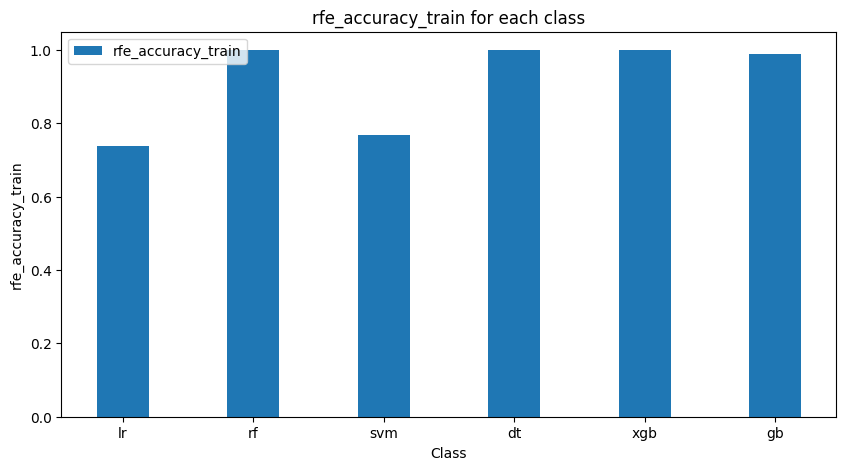

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Precision and recall values
rfe_accuracy_train = [rfe_lr_accuracy_train, rfe_rf_accuracy_train, rfe_svm_accuracy_train, rfe_dt_accuracy_train,rfe_xgb_accuracy_train, rfe_gb_accuracy_train]

# Classes
classes = ['lr', 'rf' , 'svm', 'dt', 'xgb','gb']

# Plotting rfe_accuracy_train
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(classes)), rfe_accuracy_train, width=0.4, label='rfe_accuracy_train')
plt.xticks(np.arange(len(classes)), classes)
plt.xlabel('Class')
plt.ylabel('rfe_accuracy_train')
plt.title('rfe_accuracy_train for each class')
plt.legend()
plt.show()

testing

In [ ]:
print("Testing Accuracy Score:")
print("Logistic Regression Accuracy Score:", rfe_lr_accuracy_test)
print("Random Forest Accuracy Score:", rfe_rf_accuracy_test)
print("SVM Accuracy Score:", rfe_svm_accuracy_test)
print("DT Accuracy Score:", rfe_dt_accuracy_test)
print("XGB Accuracy Score", rfe_xgb_accuracy_test)
#KNN
print("GB Accuracy Score", rfe_gb_accuracy_test)
#MLP has issue

Testing Accuracy Score:
Logistic Regression Accuracy Score: 0.7542270531400966
Random Forest Accuracy Score: 0.9420289855072463
SVM Accuracy Score: 0.8043478260869565
DT Accuracy Score: 0.9154589371980676
XGB Accuracy Score 0.9571256038647343
GB Accuracy Score 0.946256038647343


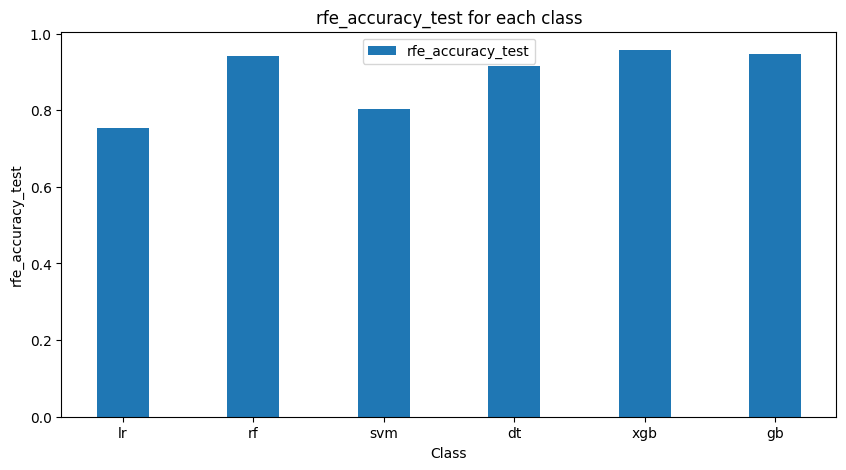

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Precision and recall values
rfe_accuracy_test = [rfe_lr_accuracy_test, rfe_rf_accuracy_test, rfe_svm_accuracy_test, rfe_dt_accuracy_test, rfe_xgb_accuracy_test, rfe_gb_accuracy_test]

# Classes
classes = ['lr', 'rf' , 'svm', 'dt', 'xgb','gb']

# Plotting rfe_accuracy_test
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(classes)), rfe_accuracy_test, width=0.4, label='rfe_accuracy_test')
plt.xticks(np.arange(len(classes)), classes)
plt.xlabel('Class')
plt.ylabel('rfe_accuracy_test')
plt.title('rfe_accuracy_test for each class')
plt.legend()
plt.show()

CV Score

In [ ]:
print("CV Score:")
print("Logistic Regression CV Score:", rfe_lr_cv_scores.mean())
print("Random Forest CV Score:", rfe_rf_cv_scores.mean())
print("SVM CV Score:", rfe_svm_cv_scores.mean())
print("DT CV Score:", rfe_dt_cv_scores.mean())
print("XGB CV Score", rfe_xgb_cv_scores.mean())
print("GB CV Score", rfe_gb_cv_scores.mean())

CV Score:
Logistic Regression CV Score: 0.6527881920430968
Random Forest CV Score: 0.9064184008762322
SVM CV Score: 0.6558093400793507
DT CV Score: 0.8659502056564626
XGB CV Score 0.9033815018381685
GB CV Score 0.9064044698431187


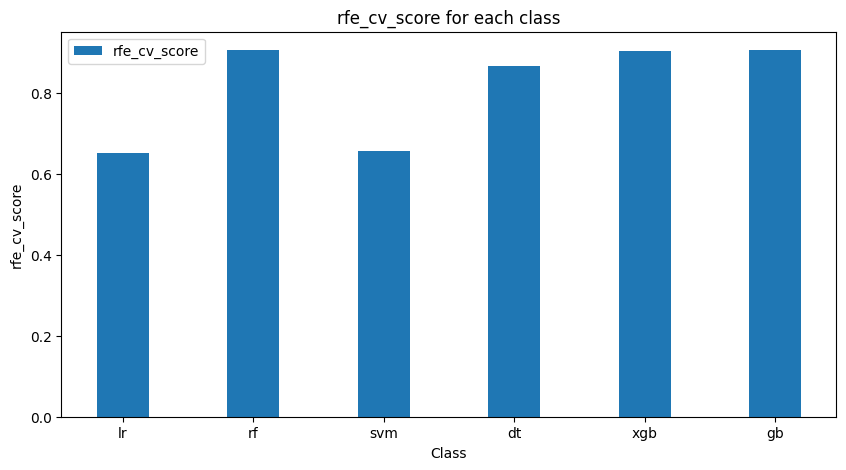

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Precision and recall values
rfe_cv_score = [rfe_lr_cv_scores.mean(), rfe_rf_cv_scores.mean(), rfe_svm_cv_scores.mean(), rfe_dt_cv_scores.mean(), rfe_xgb_cv_scores.mean(), rfe_gb_cv_scores.mean()]

# Classes
classes = ['lr', 'rf' , 'svm', 'dt', 'xgb','gb']

# Plotting rfe_accuracy_test
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(classes)), rfe_cv_score, width=0.4, label='rfe_cv_score')
plt.xticks(np.arange(len(classes)), classes)
plt.xlabel('Class')
plt.ylabel('rfe_cv_score')
plt.title('rfe_cv_score for each class')
plt.legend()
plt.show()

In [57]:
# Define estimators
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimator_list = [
    ('lr',rfe_lr_model),
    ('rf',rfe_rf_model),
    ('svm', rfe_svm_model),
    ('dt',rfe_dt_model),
    ('XGB',rfe_xgb_model),

      ]

# Build stack model
rfe_stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator= XGBClassifier(n_estimators=100, random_state=42)
)

# Train stacked model
rfe_stack_model.fit(X_train_rfe, y_train_rfe)

# Make predictions
rfe_y_train_pred_stack = rfe_stack_model.predict(X_train_rfe)
rfe_y_test_pred_stack = rfe_stack_model.predict(X_test_rfe)

# Training set model performance
rfe_stack_model_train_accuracy = accuracy_score(y_train_rfe, rfe_y_train_pred_stack) # rfelculate Accuracy
#stack_model_train_f1 = f1_score(y_train_corr, rfe_y_train_pred, average='weighted') # rfelculate F1-score

# Test set model performance
rfe_stack_model_test_accuracy = accuracy_score(y_test_rfe, rfe_y_test_pred_stack) # rfelculate Accuracy
#stack_model_test_f1 = f1_score(y_test_corr, rfe_y_test_pred, average='weighted') # rfelculate F1-score

# Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
rfe_stack_cv_scores = cross_val_score(rfe_stack_model,xgb_features_arr, y_test_rfe, cv=5, scoring='accuracy')
rfe_stack_cv_scores = np.mean(rfe_stack_cv_scores)

#Precision score on test data
rfe_precision_stack = precision_score(y_test_rfe, rfe_y_test_pred_stack, average='weighted')

from sklearn.metrics import recall_score
# Recall score on test data
rfe_Recall_stack = recall_score(y_test_rfe, rfe_y_test_pred_stack, average='weighted')

# F1-score on test data y_probabilities_lr
rfe_f1_stack = f1_score(y_test_rfe, rfe_y_test_pred_stack, average='weighted')

# Predict probabilities for ROC AUC
rfe_y_probabilities_stack = rfe_lr_model.predict_proba(X_test_rfe)

# ROC area under the curve score
rfe_roc_auc_stack = roc_auc_score(y_test_rfe, rfe_y_probabilities_stack, average='weighted', multi_class='ovr')

print('Traing Accuracy: %s' % rfe_stack_model_train_accuracy)
print('Testing Accuracy: %s' % rfe_stack_model_test_accuracy)
print("Mean CV Score on testing data:", rfe_stack_cv_scores)
print('Precision:', rfe_precision_stack)
print('Recall:', rfe_Recall_stack)
print('F1-score:', rfe_f1_stack)
print('ROC area:', rfe_roc_auc_stack)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Traing Accuracy: 0.9969806763285024
Testing Accuracy: 0.9607487922705314
Mean CV Score on testing data: 0.9148454846576639
Precision: 0.9606811434728726
Recall: 0.9607487922705314
F1-score: 0.9606803963172651
ROC area: 0.9417040295509896


Logistic with hyperparameter tunning

In [ ]:
X_rfe_lr_hy = X_rfe.iloc[:,[1,3,4,5,6,7,8,9,10,13]].values
y_rfe_lr_hy = y_rfe
# Splitting the dataset into the Training set and Test set
X_rfe_lr_hy_train, X_rfe_lr_hy_test, y_rfe_lr_hy_train, y_rfe_lr_hy_test = train_test_split(X_rfe_lr_hy, y_rfe_lr_hy, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create the estimator (Logistic Regression)
estimator = LogisticRegression()

# Define the RFE object
rfe_lr_model = RFE(estimator=estimator, n_features_to_select=10)

# Specify parameters for Logistic Regression
param_grid = [
    {'estimator__C': list(np.arange(1, 11)), 'estimator__penalty': ['l1'], 'estimator__solver': ['liblinear'], 'estimator__multi_class': ['ovr']},
    {'estimator__C': list(np.arange(1, 11)), 'estimator__penalty': ['l2'], 'estimator__solver': ['liblinear', 'newton-cg', 'lbfgs'], 'estimator__multi_class': ['ovr']}
]

# Now, perform GridSearchCV
grid_lr = GridSearchCV(rfe_lr_model, param_grid, cv=5, scoring='accuracy')
grid_lr.fit(X_rfe_lr_hy_train, y_rfe_lr_hy_train)

# Print best parameters and score
print(grid_lr.best_params_)
print(grid_lr.best_score_)

# Get the best estimator
best_rfe_lr_model = grid_lr.best_estimator_

# Make predictions
predictionforest = best_rfe_lr_model.predict(X_rfe_lr_hy_test)

rfe_lr_model.fit(X_rfe_lr_hy_train, y_rfe_lr_hy_train)
# Train accuracy
y_train_pred = grid_lr.best_estimator_.predict(X_rfe_lr_hy_train)
ig_lr_training_data_accuracy_hy = accuracy_score(y_rfe_lr_hy_train, y_train_pred)

# y_pred2=grid.best_estimator_.predict_proba(X1_test)
y_pred1=rfe_lr_model.predict_proba(X_rfe_lr_hy_test)

# labels for set 1=True to upper left and 0 = False to lower right
print ("{0}".format(metrics.classification_report(y_rfe_lr_hy_test, predictionforest, labels=[1, 0])))
ig_lr_test_data_accuracy_hy = accuracy_score(y_rfe_lr_hy_test,predictionforest)

ig_lr_cv_scores_hy = cross_val_score(grid_lr, lr_features_arr, y_rfe_lr_hy_test, cv=5, scoring='accuracy')
ig_lr_cv_scores_hy = np.mean(ig_lr_cv_scores_hy)

# Precision score on test data
precision_lr_hy = precision_score(y_rfe_lr_hy_test, predictionforest, average='weighted')

# Recall score on test data
recall_lr_hy = recall_score(y_rfe_lr_hy_test, predictionforest, average='weighted')

# F1-score on test data
f1_lr_hy = f1_score(y_rfe_lr_hy_test, predictionforest, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_lr_hy = grid_lr.predict_proba(X_rfe_lr_hy_test)

# ROC area under the curve score
roc_auc_lr_hy = roc_auc_score(y_rfe_lr_hy_test, y_probabilities_lr, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Logistic Regression:', ig_lr_training_data_accuracy_hy)
print('Accuracy score of testing data while using Logistic Regression:', ig_lr_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ig_lr_cv_scores_hy)
print('Precision:', precision_lr_hy)
print('Recall:', recall_lr_hy)
print('F1-score:', f1_lr_hy)
print('ROC area:', roc_auc_lr_hy)

{'estimator__C': 10, 'estimator__multi_class': 'ovr', 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}
0.8028357749529726
              precision    recall  f1-score   support

           1       0.79      0.78      0.79       344
           0       0.90      0.98      0.93       307

   micro avg       0.84      0.88      0.86       651
   macro avg       0.84      0.88      0.86       651
weighted avg       0.84      0.88      0.86       651

Accuracy score of training data while using Logistic Regression: 0.8129528985507246
Accuracy score of testing data while using Logistic Regression: 0.8073671497584541
Mean CV Score on testing data: 0.2137662432206166
Precision: 0.8007356507321024
Recall: 0.8073671497584541
F1-score: 0.8022707714327395
ROC area: 0.5130161383713948


Random Forest with Hyper Tunning

In [ ]:
X_rfe_rf_hy = X_rfe.iloc[:,[0,1,3,4,6,7,8,9,10,13]].values
y_rfe_rf_hy = y_rfe
# Splitting the dataset into the Training set and Test set
X_rfe_rf_hy_train, X_rfe_rf_hy_test, y_rfe_rf_hy_train, y_rfe_rf_hy_test = train_test_split(X_rfe_rf_hy, y_rfe_rf_hy, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Specify parameters for Random Forest
n_estimators_values = [50, 100, 150]
max_depth_values = [None, 10, 20, 30]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

param_grid_rf = {
    'estimator__n_estimators': n_estimators_values,
    'estimator__max_depth': max_depth_values,
    'estimator__min_samples_split': min_samples_split_values,
    'estimator__min_samples_leaf': min_samples_leaf_values
}

# Now, perform GridSearchCV
grid_rf = GridSearchCV(rfe_rf_model, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_rfe_rf_hy_train, y_rfe_rf_hy_train)

# Print best parameters and score
print(grid_rf.best_params_)
print(grid_rf.best_score_)

# Get the best estimator
best_rfe_rf_model = grid_rf.best_estimator_

# Make predictions
predictionforest = best_rfe_rf_model.predict(X_rfe_rf_hy_test)

# Train accuracy
y_train_pred = best_rfe_rf_model.predict(X_rfe_rf_hy_train)
ig_rf_training_data_accuracy_hy = accuracy_score(y_rfe_rf_hy_train, y_train_pred)

# Test accuracy
ig_rf_test_data_accuracy_hy = accuracy_score(y_rfe_rf_hy_test, predictionforest)

# Mean CV score
ig_rf_cv_scores_hy = cross_val_score(best_rfe_rf_model, rf_features_arr, y_rfe_rf_hy_test, cv=5, scoring='accuracy')
ig_rf_cv_scores_hy = np.mean(ig_rf_cv_scores_hy)

# Precision score on test data
precision_rf_hy = precision_score(y_rfe_rf_hy_test, predictionforest, average='weighted')

# Recall score on test data
recall_rf_hy = recall_score(y_rfe_rf_hy_test, predictionforest, average='weighted')

# F1-score on test data
f1_rf_hy = f1_score(y_rfe_rf_hy_test, predictionforest, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_rf_hy = best_rfe_rf_model.predict_proba(X_rfe_rf_hy_test)

# ROC area under the curve score
roc_auc_rf_hy = roc_auc_score(y_rfe_rf_hy_test, y_probabilities_rf_hy, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Random Forest Regression:', ig_rf_training_data_accuracy_hy)
print('Accuracy score of testing data while using Random Forest Regression:', ig_rf_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ig_rf_cv_scores_hy)
print('Precision:', precision_rf_hy)
print('Recall:', recall_rf_hy)
print('F1-score:', f1_rf_hy)
print('ROC area:', roc_auc_rf_hy)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 88}
0.94082209428262
Accuracy score of training data while using Random Forest Regression: 1.0
Accuracy score of testing data while using Random Forest Regression: 0.9420289855072463
Mean CV Score on testing data: 0.20108652131183344
Precision: 0.9424835685685073
Recall: 0.9420289855072463
F1-score: 0.9420117706760479
ROC area: 0.9964780933479183


SVM with hyper tunning

In [ ]:
X_rfe_svm_hy = X_rfe.iloc[:,[1,3,4,5,6,7,8,9,10,13]].values
y_rfe_svm_hy = y_rfe
# Splitting the dataset into the Training set and Test set
X_rfe_svm_hy_train, X_rfe_svm_hy_test, y_rfe_svm_hy_train, y_rfe_svm_hy_test = train_test_split(X_rfe_svm_hy, y_rfe_svm_hy, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Create the estimator (SVM)
estimator_svm = SVC(probability=True)

# Define the RFE object
rfe_svm_model = RFE(estimator=estimator_svm, n_features_to_select=10)

# Specify parameters for SVM
C_values = [0.1, 1, 10]
kernel_values = ['linear', 'rbf', 'poly']
gamma_values = ['scale', 'auto']

# Specify parameters for SVM
param_grid_svm = {
    'C': C_values,
    'kernel': kernel_values,
    'gamma': gamma_values
}

# Now, perform GridSearchCV
grid_svm = GridSearchCV(estimator_svm, param_grid_svm, cv=5, scoring='accuracy')
grid_svm.fit(X_rfe_svm_hy_train, y_rfe_svm_hy_train)

# Print best parameters and score
print(grid_svm.best_params_)
print(grid_svm.best_score_)

# Get the best estimator
best_svm_model = grid_svm.best_estimator_

# Make predictions
prediction_svm = best_svm_model.predict(X_rfe_svm_hy_test)

# Train accuracy
ig_svm_training_data_accuracy_hy = best_svm_model.score(X_rfe_svm_hy_train, y_rfe_svm_hy_train)

# Test accuracy
ig_svm_test_data_accuracy_hy = accuracy_score(y_rfe_svm_hy_test, prediction_svm)

# Mean CV score
ig_svm_cv_scores_hy = cross_val_score(best_svm_model, X_rfe_svm_hy_train, y_rfe_svm_hy_train, cv=5, scoring='accuracy')
ig_svm_cv_scores_hy = np.mean(ig_svm_cv_scores_hy)

# Precision score on test data
precision_svm_hy = precision_score(y_rfe_svm_hy_test, prediction_svm, average='weighted')

# Recall score on test data
recall_svm_hy = recall_score(y_rfe_svm_hy_test, prediction_svm, average='weighted')

# F1-score on test data
f1_svm_hy = f1_score(y_rfe_svm_hy_test, prediction_svm, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_svm_hy = best_svm_model.predict_proba(X_rfe_svm_hy_test)

# ROC area under the curve score
roc_auc_svm_hy = roc_auc_score(y_rfe_svm_hy_test, y_probabilities_svm_hy, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using SVM:', ig_svm_training_data_accuracy_hy)
print('Accuracy score of testing data while using SVM:', ig_svm_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ig_svm_cv_scores_hy)
print('Precision:', precision_svm_hy)
print('Recall:', recall_svm_hy)
print('F1-score:', f1_svm_hy)
print('ROC area:', roc_auc_svm_hy)


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.9207426323889869
Accuracy score of training data while using Decision Tree: 0.9304045893719807
Accuracy score of testing data while using Decision Tree: 0.9178743961352657
Mean CV Score on testing data: 0.9207426323889869
Precision: 0.9180818219308351
Recall: 0.9178743961352657
F1-score: 0.9177097003729351
ROC area: 0.9927848163945739


Decision tree with hyper tunning

In [ ]:
X_rfe_dt_hy = X_rfe.iloc[:,[0,1,3,6,7,9,10,11,12,13]].values
y_rfe_dt_hy = y_rfe
# Splitting the dataset into the Training set and Test set
X_rfe_dt_hy_train, X_rfe_dt_hy_test, y_rfe_dt_hy_train, y_rfe_dt_hy_test = train_test_split(X_rfe_dt_hy, y_rfe_dt_hy, test_size=0.2, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Create the estimator (Decision Tree)
estimator_dt = DecisionTreeClassifier()

# Specify parameters for Decision Tree
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Now, perform GridSearchCV
grid_dt = GridSearchCV(estimator_dt, param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_rfe_dt_hy_train, y_rfe_dt_hy_train)

# Print best parameters and score
print(grid_dt.best_params_)
print(grid_dt.best_score_)

# Get the best estimator
best_dt_model = grid_dt.best_estimator_

# Make predictions
prediction_dt = best_dt_model.predict(X_rfe_dt_hy_test)

# Train accuracy
ig_dt_training_data_accuracy_hy = best_dt_model.score(X_rfe_dt_hy_train, y_rfe_dt_hy_train)

# Test accuracy
ig_dt_test_data_accuracy_hy = accuracy_score(y_rfe_dt_hy_test, prediction_dt)

# Mean CV score
ig_dt_cv_scores_hy = cross_val_score(best_dt_model, X_rfe_dt_hy_train, y_rfe_dt_hy_train, cv=5, scoring='accuracy')
ig_dt_cv_scores_hy = np.mean(ig_dt_cv_scores_hy)

# Precision score on test data
precision_dt_hy = precision_score(y_rfe_dt_hy_test, prediction_dt, average='weighted')

# Recall score on test data
recall_dt_hy = recall_score(y_rfe_dt_hy_test, prediction_dt, average='weighted')

# F1-score on test data
f1_dt_hy = f1_score(y_rfe_dt_hy_test, prediction_dt, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_dt_hy = best_dt_model.predict_proba(X_rfe_dt_hy_test)

# ROC area under the curve score
roc_auc_dt_hy = roc_auc_score(y_rfe_dt_hy_test, y_probabilities_dt_hy, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Decision Tree:', ig_dt_training_data_accuracy_hy)
print('Accuracy score of testing data while using Decision Tree:', ig_dt_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ig_dt_cv_scores_hy)
print('Precision:', precision_dt_hy)
print('Recall:', recall_dt_hy)
print('F1-score:', f1_dt_hy)
print('ROC area:', roc_auc_dt_hy)


{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.9068535598244314
Accuracy score of training data while using Decision Tree: 1.0
Accuracy score of testing data while using Decision Tree: 0.894927536231884
Mean CV Score on testing data: 0.9071551046001254
Precision: 0.8952948609707524
Recall: 0.894927536231884
F1-score: 0.8949998257603169
ROC area: 0.9341317132507918


XGBoost with hyper tunning

In [ ]:
X_rfe_xgb_hy = X_rfe.iloc[:,[0,1,2,6,7,8,9,11,12,13]].values
y_rfe_xgb_hy = y_rfe
# Splitting the dataset into the Training set and Test set
X_rfe_xgb_hy_train, X_rfe_xgb_hy_test, y_rfe_xgb_hy_train, y_rfe_xgb_hy_test = train_test_split(X_rfe_xgb_hy, y_rfe_xgb_hy, test_size=0.2, random_state=42)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import numpy as np

from sklearn.preprocessing import LabelEncoder

# Convert class labels to integers
label_encoder = LabelEncoder()
y_rfe_xgb_hy_train = label_encoder.fit_transform(y_rfe_xgb_hy_train)

# Create the estimator (XGBoost)
estimator_xgb = xgb.XGBClassifier(objective='multi:softprob')

# Now, define the RFE object
rfe_xgb_model = RFE(estimator=estimator_xgb, n_features_to_select=10)

# Specify parameters for XGBoost
param_grid_xgb = {
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7],
    'estimator__subsample': [0.8, 1.0],
    'estimator__colsample_bytree': [0.8, 1.0],
    'estimator__n_estimators': [50, 100, 150]
}

# Now, perform GridSearchCV
grid_xgb = GridSearchCV(rfe_xgb_model, param_grid_xgb, cv=5, scoring='accuracy')
grid_xgb.fit(X_rfe_xgb_hy_train, y_rfe_xgb_hy_train)

# Print best parameters and score
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)

# Get the best estimator
best_rfe_xgb_model = grid_xgb.best_estimator_

# Make predictions
prediction_xgb = best_rfe_xgb_model.predict(X_rfe_xgb_hy_test)

# Train accuracy
ig_xgb_training_data_accuracy_hy = best_rfe_xgb_model.score(X_rfe_xgb_hy_train, y_rfe_xgb_hy_train)

# Test accuracy
ig_xgb_test_data_accuracy_hy = accuracy_score(y_rfe_xgb_hy_test, prediction_xgb)

# Mean CV score
ig_xgb_cv_scores_hy = cross_val_score(best_rfe_xgb_model, X_rfe_xgb_hy_train, y_rfe_xgb_hy_train, cv=5, scoring='accuracy')
ig_xgb_cv_scores_hy = np.mean(ig_xgb_cv_scores_hy)

# Convert class labels to integers for test set
y_rfe_xgb_hy_test = label_encoder.transform(y_rfe_xgb_hy_test)

# Precision score on test data
precision_xgb_hy = precision_score(y_rfe_xgb_hy_test, prediction_xgb, average='weighted')

# Recall score on test data
recall_xgb_hy = recall_score(y_rfe_xgb_hy_test, prediction_xgb, average='weighted')

# F1-score on test data
f1_xgb_hy = f1_score(y_rfe_xgb_hy_test, prediction_xgb, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_xgb_hy = best_rfe_xgb_model.predict_proba(X_rfe_xgb_hy_test)

# ROC area under the curve score
roc_auc_xgb_hy = roc_auc_score(y_rfe_xgb_hy_test, y_probabilities_xgb_hy, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using XGBoost:', ig_xgb_training_data_accuracy_hy)
print('Accuracy score of testing data while using XGBoost:', ig_xgb_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ig_xgb_cv_scores_hy)
print('Precision:', precision_xgb_hy)
print('Recall:', recall_xgb_hy)
print('F1-score:', f1_xgb_hy)
print('ROC area:', roc_auc_xgb_hy)


{'estimator__colsample_bytree': 1.0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 7, 'estimator__n_estimators': 150, 'estimator__subsample': 0.8}
0.9593904121301943
Accuracy score of training data while using XGBoost: 1.0
Accuracy score of testing data while using XGBoost: 0.0
Mean CV Score on testing data: 0.9593904121301943
Precision: 0.961978376059219
Recall: 0.961352657004831
F1-score: 0.961371675022635
ROC area: 0.9981817044397564


Gradient Boost with hyper tunning

In [ ]:
X_rfe_gb_hy = X_rfe.iloc[:,[0,1,3,6,7,9,10,11,12,13]].values
y_rfe_gb_hy = y_rfe
# Splitting the dataset into the Training set and Test set
X_rfe_gb_hy_train, X_rfe_gb_hy_test, y_rfe_gb_hy_train, y_rfe_gb_hy_test = train_test_split(X_rfe_gb_hy, y_rfe_gb_hy, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Create the estimator (Gradient Boost)
estimator_gb = GradientBoostingClassifier()

# Specify parameters for Gradient Boost
param_dist_gb = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2]
}

# Now, perform RandomizedSearchCV
random_gb = RandomizedSearchCV(estimator_gb, param_distributions=param_dist_gb, n_iter=10, cv=5, scoring='accuracy')
random_gb.fit(X_rfe_gb_hy_train, y_rfe_gb_hy_train)

# Print best parameters and score
print(random_gb.best_params_)
print(random_gb.best_score_)

# Get the best estimator
best_gb_model = random_gb.best_estimator_

# Make predictions
prediction_gb = best_gb_model.predict(X_rfe_gb_hy_test)

# Train accuracy
ig_gb_training_data_accuracy_hy = best_gb_model.score(X_rfe_gb_hy_train, y_rfe_gb_hy_train)

# Test accuracy
ig_gb_test_data_accuracy_hy = accuracy_score(y_rfe_gb_hy_test, prediction_gb)

# Mean CV score
ig_gb_cv_scores_hy = cross_val_score(best_gb_model, X_rfe_gb_hy_train, y_rfe_gb_hy_train, cv=5, scoring='accuracy')
ig_gb_cv_scores_hy = np.mean(ig_gb_cv_scores_hy)

# Precision score on test data
precision_gb_hy = precision_score(y_rfe_gb_hy_test, prediction_gb, average='weighted')

# Recall score on test data
recall_gb_hy = recall_score(y_rfe_gb_hy_test, prediction_gb, average='weighted')

# F1-score on test data
f1_gb_hy = f1_score(y_rfe_gb_hy_test, prediction_gb, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_gb_hy = best_gb_model.predict_proba(X_rfe_gb_hy_test)

# ROC area under the curve score
roc_auc_gb_hy = roc_auc_score(y_rfe_gb_hy_test, y_probabilities_gb_hy, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Gradient Boost:', ig_gb_training_data_accuracy_hy)
print('Accuracy score of testing data while using Gradient Boost:', ig_gb_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ig_gb_cv_scores_hy)
print('Precision:', precision_gb_hy)
print('Recall:', recall_gb_hy)
print('F1-score:', f1_gb_hy)
print('ROC area:', roc_auc_gb_hy)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Create the estimator (Gradient Boost)
estimator_gb = GradientBoostingClassifier()

# # Specify parameters for Gradient Boost
# param_grid_gb = {
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# Specify parameters for Gradient Boost
param_grid_gb = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2]
}

# Now, perform GridSearchCV
grid_gb = GridSearchCV(estimator_gb, param_grid_gb, cv=5, scoring='accuracy')
grid_gb.fit(X_rfe_gb_hy_train, y_rfe_gb_hy_train)

# Print best parameters and score
print(grid_gb.best_params_)
print(grid_gb.best_score_)

# Get the best estimator
best_gb_model = grid_gb.best_estimator_

# Make predictions
prediction_gb = best_gb_model.predict(X_rfe_gb_hy_test)

# Train accuracy
ig_gb_training_data_accuracy_hy = best_gb_model.score(X_rfe_gb_hy_train, y_rfe_gb_hy_train)

# Test accuracy
ig_gb_test_data_accuracy_hy = accuracy_score(y_rfe_gb_hy_test, prediction_gb)

# Mean CV score
ig_gb_cv_scores_hy = cross_val_score(best_gb_model, X_rfe_gb_hy_train, y_rfe_gb_hy_train, cv=5, scoring='accuracy')
ig_gb_cv_scores_hy = np.mean(ig_gb_cv_scores_hy)

# Precision score on test data
precision_gb_hy = precision_score(y_rfe_gb_hy_test, prediction_gb, average='weighted')

# Recall score on test data
recall_gb_hy = recall_score(y_rfe_gb_hy_test, prediction_gb, average='weighted')

# F1-score on test data
f1_gb_hy = f1_score(y_rfe_gb_hy_test, prediction_gb, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_gb_hy = best_gb_model.predict_proba(X_rfe_gb_hy_test)

# ROC area under the curve score
roc_auc_gb_hy = roc_auc_score(y_rfe_gb_hy_test, y_probabilities_gb_hy, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Decision Tree:', ig_gb_training_data_accuracy_hy)
print('Accuracy score of testing data while using Decision Tree:', ig_gb_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ig_gb_cv_scores_hy)
print('Precision:', precision_gb_hy)
print('Recall:', recall_gb_hy)
print('F1-score:', f1_gb_hy)
print('ROC area:', roc_auc_gb_hy)


{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.950030439491535
Accuracy score of training data while using Decision Tree: 1.0
Accuracy score of testing data while using Decision Tree: 0.9553140096618358
Mean CV Score on testing data: 0.950030439491535
Precision: 0.9557578853286933
Recall: 0.9553140096618358
F1-score: 0.9552147512137212
ROC area: 0.9973753171717762


Staking

In [ ]:
# Define estimators
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimator_list = [
    ('lr',rfe_lr_model),
    ('rf',rfe_rf_model),
    ('svm', rfe_svm_model),
    ('dt',rfe_dt_model),
    ('XGB',rfe_xgb_model),
    ('GB',rfe_gb_model),
      ]

# Build stack model
rfe_stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator= GradientBoostingClassifier()
)

# Train stacked model
rfe_stack_model.fit(X_train_rfe, y_train_rfe)

# Make predictions
rfe_y_train_pred_stack = rfe_stack_model.predict(X_train_rfe)
rfe_y_test_pred_stack = rfe_stack_model.predict(X_test_rfe)

# Training set model performance
rfe_stack_model_train_accuracy = accuracy_score(y_train_rfe, rfe_y_train_pred_stack) # rfelculate Accuracy
#stack_model_train_f1 = f1_score(y_train_corr, rfe_y_train_pred, average='weighted') # rfelculate F1-score

# Test set model performance
rfe_stack_model_test_accuracy = accuracy_score(y_test_rfe, rfe_y_test_pred_stack) # rfelculate Accuracy
#stack_model_test_f1 = f1_score(y_test_corr, rfe_y_test_pred, average='weighted') # rfelculate F1-score

# Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
rfe_stack_cv_scores = cross_val_score(rfe_stack_model, gb_features_arr, y_test_rfe, cv=5, scoring='accuracy')
rfe_stack_cv_scores = np.mean(rfe_stack_cv_scores)

#Precision score on test data
rfe_precision_stack = precision_score(y_test_rfe, rfe_y_test_pred_stack, average='weighted')

from sklearn.metrics import recall_score
# Recall score on test data
rfe_Recall_stack = recall_score(y_test_rfe, rfe_y_test_pred_stack, average='weighted')

# F1-score on test data y_probabilities_lr
rfe_f1_stack = f1_score(y_test_rfe, rfe_y_test_pred_stack, average='weighted')

# Predict probabilities for ROC AUC
rfe_y_probabilities_stack = rfe_lr_model.predict_proba(X_test_rfe)

# ROC area under the curve score
rfe_roc_auc_stack = roc_auc_score(y_test_rfe, rfe_y_probabilities_stack, average='weighted', multi_class='ovr')

print('Traing Accuracy: %s' % rfe_stack_model_train_accuracy)
print('Testing Accuracy: %s' % rfe_stack_model_test_accuracy)
print("Mean CV Score on testing data:", rfe_stack_cv_scores)
print('Precision:', rfe_precision_stack)
print('Recall:', rfe_Recall_stack)
print('F1-score:', rfe_f1_stack)
print('ROC area:', rfe_roc_auc_stack)

ENDDDDDDDDDDDDDDDDD---------------------------------------